# Recommendation System - Collaborative Filtering on Anime dataset

## 1.Introduction
#### 1.1 Background
Anime is  hand-drawn and computer animation originating from Japan. The word anime is the Japanese term for animation, which refers to all forms of animated media. Outside Japan, anime refers specifically to animation from Japan or as a Japanese-disseminated animation style often characterized by colorful graphics, vibrant characters and fantastical themes.Recommendation systems are a collection of algorithms used to recommend items to users based on information taken from the user. These systems have become ubiquitous can be commonly seen in online stores, movies databases and job finders. In this report, we will explore recommendation systems based on Collaborative Filtering and implement simple version of one using Python and the Pandas library. Collaborative filtering basis this similarity on things like history, preference, and choices that users make when buying, watching, or enjoying something. For example, movies that similar users have rated highly. Then it uses the ratings from these similar users to predict the possible ratings by the active user for a movie that she had not previously watched. For instance, if two users are similar or are neighbors in terms of their interested movies, we can recommend a movie to the active user that her neighbor has already seen.
#### 1.2 Problem
When a user want to watch a new series/ anime he /she would look fro different sources in order to choose a anime to their interest so  by using the dataset we have we can recommend anime which might be to their interest.
#### 1.3 Interest
As anime being one of the popluar interest among many users in the internet this recommendation engine helps the users to find their similar interest with respective to other users. 

## 2. Data acquisition
Anime_id, name, genre,rating, user_id all of these values can be obtained from these two Kaggle datasets [Anime Dataset](https://www.kaggle.com/CooperUnion/anime-recommendations-database?select=anime.csv) and [Ratings dataset](https://www.kaggle.com/CooperUnion/anime-recommendations-database?select=rating.csv).
### 2.1 Data Content
#### Anime.csv

- anime_id - myanimelist.net's unique id identifying an anime.
- name - full name of anime.
- genre - comma separated list of genres for this anime.
- type - movie, TV, OVA, etc.
- episodes - how many episodes in this show. (1 if movie).
- rating - average rating out of 10 for this anime.
- members - number of community members that are in this anime's "group".

#### Rating.csv

- user_id - non identifiable randomly generated user id.
- anime_id - the anime that this user has rated.
- rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

### 2.2 Data CLeaning
First, let's get all of the imports out of the way:

In [2]:
#Dataframe manipulation library
import pandas as pd
#Math functions, we'll only need the sqrt function so let's import only that
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import collections
import seaborn as sns

Now let's read each file into their Dataframes:

In [3]:
#Storing the movie information into a pandas dataframe
anime_df = pd.read_csv('anime.csv')
#Storing the user information into a pandas dataframe
ratings_df = pd.read_csv('ratingAnime.csv')

Let's  take a look how these datasets are arranged, this helps us to familiarize ourselves with datasets.

In [4]:
#Head is a function that gets the first N rows of a dataframe. N's default is 5.
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Next, let's look at the ratings dataframe.

In [5]:
ratings_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Before alteration the ratings dataset uses a "-1" to represent missing ratings. I'm replacing these placeholders with a null value. In further process we need to calculate the mean.

In [6]:
ratings_df.rating.replace({-1: np.nan}, inplace = True)
ratings_df.head()

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN


Our datasets are ready.

## Data Visualization

In [7]:
anime_df = anime_df.replace('Unknown',np.nan)
anime_df = anime_df.dropna()
anime_df['episodes'] = anime_df['episodes'].astype('int64')

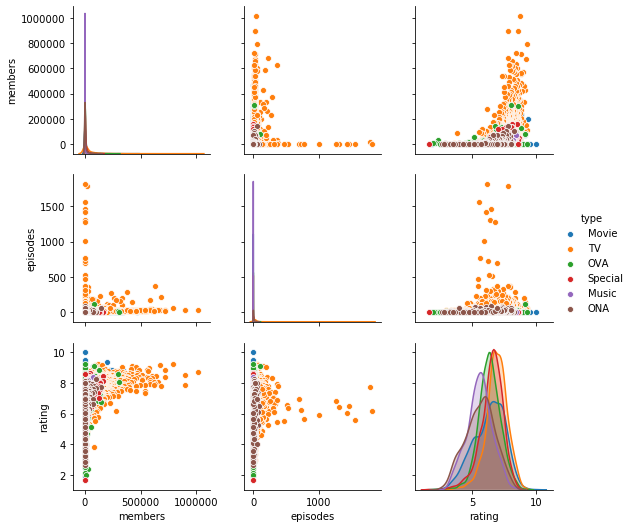

In [8]:
sns.pairplot(data=anime_df[['type','members','episodes','rating']],hue='type')

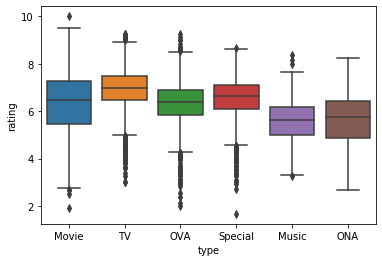

In [9]:
sns.boxplot(data=anime_df,x='type',y='rating')

In [10]:
anime_df['genre']=anime_df['genre'].apply(lambda x : x.split(', '))
genre_data = itertools.chain(*anime_df['genre'].values.tolist())
genre_counts = collections.Counter(genre_data)

In [11]:
genre_counts

Counter({'Drama': 1972,
         'Romance': 1436,
         'School': 1164,
         'Supernatural': 993,
         'Action': 2748,
         'Adventure': 2293,
         'Fantasy': 2219,
         'Magic': 742,
         'Military': 415,
         'Shounen': 1669,
         'Comedy': 4483,
         'Historical': 787,
         'Parody': 397,
         'Samurai': 145,
         'Sci-Fi': 2028,
         'Thriller': 86,
         'Sports': 527,
         'Super Power': 445,
         'Space': 376,
         'Slice of Life': 1180,
         'Mecha': 927,
         'Music': 832,
         'Mystery': 482,
         'Seinen': 530,
         'Martial Arts': 258,
         'Vampire': 100,
         'Shoujo': 587,
         'Horror': 360,
         'Police': 194,
         'Psychological': 226,
         'Demons': 287,
         'Ecchi': 627,
         'Josei': 52,
         'Shounen Ai': 62,
         'Game': 170,
         'Dementia': 238,
         'Harem': 312,
         'Cars': 71,
         'Kids': 1550,
         'Shoujo 

In [12]:
genre = pd.DataFrame.from_dict(genre_counts,orient='index').reset_index().rename(columns={'index':'genre',0:'counts'})
genre = genre.sort_values('counts',ascending=False)

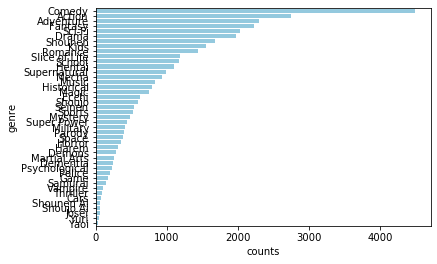

In [13]:
sns.barplot(y=genre['genre'],x=genre['counts'],color='skyblue')

# Collaborative Filtering

Now, time to start our work on recommendation systems. 

The first technique we're going to take a look at is called __Collaborative Filtering__, which is also known as __User-User Filtering__. As hinted by its alternate name, this technique uses other users to recommend items to the input user. It attempts to find users that have similar preferences and opinions as the input and then recommends items that they have liked to the input. There are several methods of finding similar users (Even some making use of Machine Learning), and the one we will be using here is going to be based on the __Pearson Correlation Function__.

The process for creating a User Based recommendation system is as follows:
- Select a user with the movies the user has watched
- Based on his rating to movies, find the top X neighbours 
- Get the watched movie record of the user for each neighbour.
- Calculate a similarity score using some formula
- Recommend the items with the highest score


Let's begin by creating an input user to recommend movies to:


In [14]:
userInput = [
            {'name':'Kimi no Na wa.', 'rating':9.5},
            {'name':'Mononoke Hime', 'rating':7.5},
            {'name':'One Punch Man', 'rating':9.0},
            {'name':'Bungou Stray Dogs 2nd Season', 'rating':9.2},
            {'name':'Great Teacher Onizuka', 'rating':8.0}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,name,rating
0,Kimi no Na wa.,9.5
1,Mononoke Hime,7.5
2,One Punch Man,9.0
3,Bungou Stray Dogs 2nd Season,9.2
4,Great Teacher Onizuka,8.0


#### Add movieId to input user
With the input complete, let's extract the input anime ID's from the anime dataframe and add them into it.

We can achieve this by first filtering out the rows that contain the input movies' title and then merging this subset with the input dataframe. We also drop unnecessary columns for the input to save memory space.

In [15]:
#Filtering out the movies by title
inputMovies = anime_df[anime_df['name'].isin(inputMovies['name'].tolist())]
inputMovies


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630
23,30276,One Punch Man,"[Action, Comedy, Parody, Sci-Fi, Seinen, Super...",TV,12,8.82,552458
24,164,Mononoke Hime,"[Action, Adventure, Fantasy]",Movie,1,8.81,339556
30,245,Great Teacher Onizuka,"[Comedy, Drama, School, Shounen, Slice of Life]",TV,43,8.77,268487
161,32867,Bungou Stray Dogs 2nd Season,"[Mystery, Seinen, Supernatural]",TV,12,8.39,83641


#### The users who has seen the same movies
Now with the movie ID's in our input, we can now get the subset of users that have watched and reviewed the movies in our input.


In [16]:
#Filtering out users that have watched movies that the input has watched and storing it
userSubset = ratings_df[ratings_df['anime_id'].isin(inputMovies['anime_id'].tolist())]
userSubset.head()

,user_id,anime_id,rating
246,3,30276,NaN
338,5,245,10.0
822,7,245,8.0
1103,7,30276,8.0
1182,11,164,8.0


We now group up the rows by user ID.

In [17]:
#Groupby creates several sub dataframes where they all have the same value in the column specified as the parameter
userSubsetGroup = userSubset.groupby(['user_id'])

lets look at one of the users, e.g. the one with userID=20

In [18]:
userSubsetGroup.get_group(5)

,user_id,anime_id,rating
338,5,245,10.0


Let's also sort these groups so the users that share the most movies in common with the input have higher priority. This provides a richer recommendation since we won't go through every single user.

In [19]:
#Sorting it so users with movie most in common with the input will have priority
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

Now lets look at the first user

In [20]:
userSubsetGroup[0:3]

[(784,
         user_id  anime_id  rating
  75639      784       164     9.0
  75647      784       245     8.0
  75980      784     30276     9.0
  76023      784     32281     9.0),
 (2243,
          user_id  anime_id  rating
  217638     2243       164     NaN
  217651     2243       245     NaN
  218376     2243     30276     NaN
  218385     2243     32281     NaN),
 (2819,
          user_id  anime_id  rating
  271457     2819       164     9.0
  271463     2819       245     9.0
  271679     2819     30276     9.0
  271685     2819     32281     9.0)]

#### Similarity of users to input user
Next, we are going to compare all users (not really all !!!) to our specified user and find the one that is most similar.  
we're going to find out how similar each user is to the input through the __Pearson Correlation Coefficient__. It is used to measure the strength of a linear association between two variables. The formula for finding this coefficient between sets X and Y with N values can be seen in the image below. 

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/bd1ccc2979b0fd1c1aec96e386f686ae874f9ec0 "Pearson Correlation")

We will select a subset of users to iterate through. This limit is imposed because we don't want to waste too much time going through every single user.

In [21]:
userSubsetGroup = userSubsetGroup[0:100]
userSubsetGroup

[(784,
         user_id  anime_id  rating
  75639      784       164     9.0
  75647      784       245     8.0
  75980      784     30276     9.0
  76023      784     32281     9.0),
 (2243,
          user_id  anime_id  rating
  217638     2243       164     NaN
  217651     2243       245     NaN
  218376     2243     30276     NaN
  218385     2243     32281     NaN),
 (2819,
          user_id  anime_id  rating
  271457     2819       164     9.0
  271463     2819       245     9.0
  271679     2819     30276     9.0
  271685     2819     32281     9.0),
 (4437,
          user_id  anime_id  rating
  430654     4437       164     9.0
  430660     4437       245     8.0
  430963     4437     30276     6.0
  430995     4437     32281     6.0),
 (4821,
          user_id  anime_id  rating
  468344     4821       164     8.0
  468351     4821       245    10.0
  468456     4821     30276    10.0
  468460     4821     32281    10.0),
 (5053,
          user_id  anime_id  rating
  495728    

Now, we calculate the Pearson Correlation between input user and subset group, and store it in a dictionary, where the key is the user Id and the value is the coefficient


In [22]:
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient
pearsonCorrelationDict = {}

#For every user group in our subset
for name, group in userSubsetGroup:
    #Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='anime_id')
    inputMovies = inputMovies.sort_values(by='anime_id')
    #Get the N for the formula
    nRatings = len(group)
    #Get the review scores for the movies that they both have in common
    temp_df = inputMovies[inputMovies['anime_id'].isin(group['anime_id'].tolist())]
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp_df['rating'].tolist()
    #Let's also put the current user group reviews in a list format
    tempGroupList = group['rating'].tolist()
    #Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0


In [23]:
pearsonCorrelationDict.items()

dict_items([(784, 0.4023545918545613), (2243, nan), (2819, 0), (4437, -0.5772913709216773), (4821, 0.3090549763520803), (5053, 0.8570116919212343), (5166, 0.7272125623106391), (6164, nan), (7198, 0.8570116919212343), (7249, 0.5085581601556316), (7448, 0), (8198, 0.8570116919212343), (10442, 0.3090549763520803), (11293, 0.3090549763520803), (12174, 0.30905497635214657), (12338, nan), (12684, 0.5958987992652245), (13208, 0.42882314022547935), (13548, nan), (13635, nan), (13877, 0.30905497635204715), (14094, 0.5150989620766406), (14406, 0.30905497635214657), (14556, -0.997139640682853), (14636, -0.9483588678062593), (14949, nan), (15221, 0.6160987585622125), (15757, 0.7855940509277846), (15900, 0.8313555552244449), (15981, 0.5150989620766406), (16600, nan), (16784, 0.9971396406829856), (17033, 0.515098962076698), (17311, 0), (17333, nan), (17432, 0.9971396406829856), (18417, -0.8570116919211531), (18477, 0.9059838490725327), (18911, 0.4024306441360954), (19070, -0.6160987585620977), (1914

In [24]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['user_id'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,user_id
0,0.402355,784
1,NaN,2243
2,0.000000,2819
3,-0.577291,4437
4,0.309055,4821


#### The top x similar users to input user
Now let's get the top 50 users that are most similar to the input.

In [25]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,user_id
63,0.99714,28238
98,0.99714,41865
31,0.99714,16784
84,0.99714,37007
35,0.99714,17432


Now, let's start recommending movies to the input user.

#### Rating of selected users to all movies
We're going to do this by taking the weighted average of the ratings of the movies using the Pearson Correlation as the weight. But to do this, we first need to get the movies watched by the users in our __pearsonDF__ from the ratings dataframe and then store their correlation in a new column called _similarityIndex". This is achieved below by merging of these two tables.

In [26]:
topUsersRating=topUsers.merge(ratings_df, left_on='user_id', right_on='user_id', how='inner')
topUsersRating.head()

,similarityIndex,user_id,anime_id,rating
0,0.99714,28238,6,9.0
1,0.99714,28238,19,9.0
2,0.99714,28238,20,8.0
3,0.99714,28238,30,9.0
4,0.99714,28238,31,8.0


Now all we need to do is simply multiply the movie rating by its weight (The similarity index), then sum up the new ratings and divide it by the sum of the weights.

We can easily do this by simply multiplying two columns, then grouping up the dataframe by anime_id and then dividing two columns:

It shows the idea of all similar users to candidate movies for the input user:

In [27]:
#Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

,similarityIndex,user_id,anime_id,rating,weightedRating
0,0.99714,28238,6,9.0,8.974257
1,0.99714,28238,19,9.0,8.974257
2,0.99714,28238,20,8.0,7.977117
3,0.99714,28238,30,9.0,8.974257
4,0.99714,28238,31,8.0,7.977117


In [28]:
#Applies a sum to the topUsers after grouping it up by userId
tempTopUsersRating = topUsersRating.groupby('anime_id').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
anime_id,,
1,21.250480,169.511458
5,12.711038,103.985417
6,14.218193,111.618654
7,3.776349,28.799817
8,0.917454,4.700012


In [29]:
#Creates an empty dataframe
recommendation_df = pd.DataFrame()
#Now we take the weighted average
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['anime_id'] = tempTopUsersRating.index
recommendation_df.head()

,weighted average recommendation score,anime_id
anime_id,,
1,7.976830,1
5,8.180718,5
6,7.850411,6
7,7.626365,7
8,5.122888,8


Now let's sort it and see the top 20 movies that the algorithm recommended!

In [30]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(10)

,weighted average recommendation score,anime_id
anime_id,,
6855,10.0,6855
2623,10.0,2623
28851,10.0,28851
1087,10.0,1087
17699,10.0,17699
1395,10.0,1395
12661,10.0,12661
1079,10.0,1079
996,10.0,996


In [31]:
anime_df.loc[anime_df['anime_id'].isin(recommendation_df.head(10)['anime_id'].tolist())]

,anime_id,name,genre,type,episodes,rating,members
11,28851,Koe no Katachi,"[Drama, School, Shounen]",Movie,1,9.05,102733
467,2623,Flanders no Inu (Movie),"[Drama, Historical]",Movie,1,8.05,8505
534,996,Bishoujo Senshi Sailor Moon: Sailor Stars,"[Adventure, Comedy, Drama, Fantasy, Magic, Rom...",TV,34,7.99,52586
1011,1395,Future GPX Cyber Formula Sin,"[Drama, Sci-Fi, Shounen, Sports]",OVA,5,7.72,1070
1063,1087,Kimagure Orange☆Road,"[Comedy, Drama, Romance, School, Shounen, Slic...",TV,48,7.70,16012
1968,3508,Genius Party,"[Action, Dementia, Fantasy, Mecha, Music, Psyc...",Movie,7,7.39,18612
2427,17699,Toriko Movie: Bishokushin no Special Menu,"[Action, Adventure, Fantasy, Shounen]",Movie,1,7.27,3077
2635,1079,Armitage III,"[Action, Adventure, Mecha, Police, Romance, Sc...",OVA,4,7.20,14930
4013,6855,Da Nao Tiangong,[Adventure],Movie,1,6.82,342
4683,12661,Light Lag,[Music],Music,1,6.66,891


Finally we have obtained recommendations based on similar user.